In [1]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np
import geopandas as gpd

In [2]:
url='https://data.buffalony.gov/resource/d6g9-xbgu.json'

In [3]:
df_list = []
offset = 0
limit = 1000  # Adjust this value as needed
cutoff_date = datetime(2009, 1, 1)  # Set the cutoff date to the end of 2009

while True:
    params = {
        '$limit': limit,
        '$offset': offset,
        '$order': 'incident_datetime DESC'  # Sort by incident_datetime in descending order
    }
    response = requests.get(url, params=params)
    data = response.json()
    df_page = pd.DataFrame(data)

    if df_page.empty:
        break

    # Convert incident_datetime to datetime objects
    df_page['incident_datetime'] = pd.to_datetime(df_page['incident_datetime'])

    # Check if we've reached data before or equal to 2009
    if df_page['incident_datetime'].min() <= cutoff_date:
        # Filter out rows after 2009
        df_page = df_page[df_page['incident_datetime'] <= cutoff_date]
        df_list.append(df_page)
        break

    df_list.append(df_page)
    offset += limit

df = pd.concat(df_list, ignore_index=True)

In [4]:
df.to_csv('dataset.csv')

In [5]:
df['incident_description'].value_counts()

incident_description
Buffalo Police are investigating this report of a crime.  It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.    251377
Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.       5177
LARCENY/THEFT                                                                                                                                                                                                                 2012
BURGLARY                                                                                                                                                                                                                      1061
ASSAULT                                                                

In [6]:
'''
As we can see above, there are two same incident descriptions with an extra space in one of them in the incident_description column.
So, this can be rectified using regex. 'r\s+' identifies unwanted spaces in the middle of the text and the rreplace method replaces it with a single space.
'''
df['incident_description'] = df['incident_description'].str.replace(r'\s+', ' ', regex=True)

In [7]:

df['incident_description']=df['incident_description'].str.replace('Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','under investigation')

In [8]:
df['incident_description']=df['incident_description'].str.replace('Buffalo Police are investigating this report of a crime. It is important to note that this is very preliminary information and further investigation as to the facts and circumstances of this report may be necessary.','under investigation')

In [9]:
df=df.replace('UNKNOWN',np.nan)

In [10]:
df=df.sort_values(by='incident_datetime')

In [11]:
df['year'] = df['incident_datetime'].dt.year
df['month'] = df['incident_datetime'].dt.month
df['day'] = df['incident_datetime'].dt.day
df['weekday'] = df['incident_datetime'].dt.weekday
df['hour'] = df['incident_datetime'].dt.hour


In [12]:
df['incident_type_primary']=df['incident_type_primary'].str.lower()
df['parent_incident_type']=df['parent_incident_type'].str.lower()
df['address_1']=df['address_1'].str.lower()

In [13]:
df['latitude']=df['latitude'].astype('float64')
df['longitude']=df['longitude'].astype('float64')

In [14]:
df.isnull().sum()

case_number                     0
incident_datetime               0
incident_type_primary           0
incident_description            0
parent_incident_type            0
hour_of_day                     0
day_of_week                     0
address_1                      33
city                            0
state                           0
location                     6087
latitude                     6087
longitude                    6087
created_at                 189018
zip_code                     3377
neighborhood                 6075
council_district             2388
council_district_2011        3431
census_tract                 5982
census_block_group           5982
census_block                 5982
census_tract_2010           19529
census_block_group_2010     19561
census_block_2010           19531
police_district              5989
tractce20                    5982
geoid20_tract                5982
geoid20_blockgroup           5982
geoid20_block                5982
year          

In [15]:
#As we can see created_at column has too many null values, hence dropping that column
df_filtered=df.drop(columns=['created_at'])

In [16]:
#The remaining null values are very less in number when compared to the total size of the dataset, hence we can drop it
df_filtered.dropna(axis='index',inplace=True)

In [17]:
# Categorize incident types into broader crime categories (sexual, assault, vehicle, theft, murder)
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].str.lower()

sexual_crimes = ['other sexual offense','sexual assault', 'rape', 'sexual abuse', 'sodomy']
assault_crimes=['agg assault on p/officer', 'aggr assault', 'assault']
vehicle_crimes=['theft of vehicles', 'uuv','theft of vehicle']
theft_crimes=['burglary', 'larceny/theft','robbery', 'theft of services','theft', 'breaking & entering']
murder_crimes=['crim negligent homicide', 'homicide', 'manslaughter', 'murder']
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(sexual_crimes, 'sexual crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(assault_crimes, 'assault crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(vehicle_crimes, 'vehicle crime')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(theft_crimes,'theft crimes')
df_filtered['incident_type_primary'] = df_filtered['incident_type_primary'].replace(murder_crimes,'murder crimes')

In [18]:
# Convert crime data to GeoDataFrame
gdf_crimes = gpd.GeoDataFrame(
    df_filtered,
    geometry=gpd.points_from_xy(df_filtered.longitude, df_filtered.latitude),
    crs="EPSG:4326"
)

## ***Question 1: Are there more businesses located in areas with higher crime rates compared to areas with lower crime rates?****

/var/folders/74/kxw5x5pj4m37f03sw19cwf4c0000gp/T/ipykernel_75903/1031834083.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  businesses['License Date'] = pd.to_datetime(businesses['License Date'])


Chi-Square Statistic: 100.28965911255
p-value: 1.6686960108494019e-22
There is a statistically significant difference in business distribution across crime categories.

Observed Counts by Crime Category:
crime_category
Low       3292
Medium    3227
High      3983
Name: count, dtype: int64


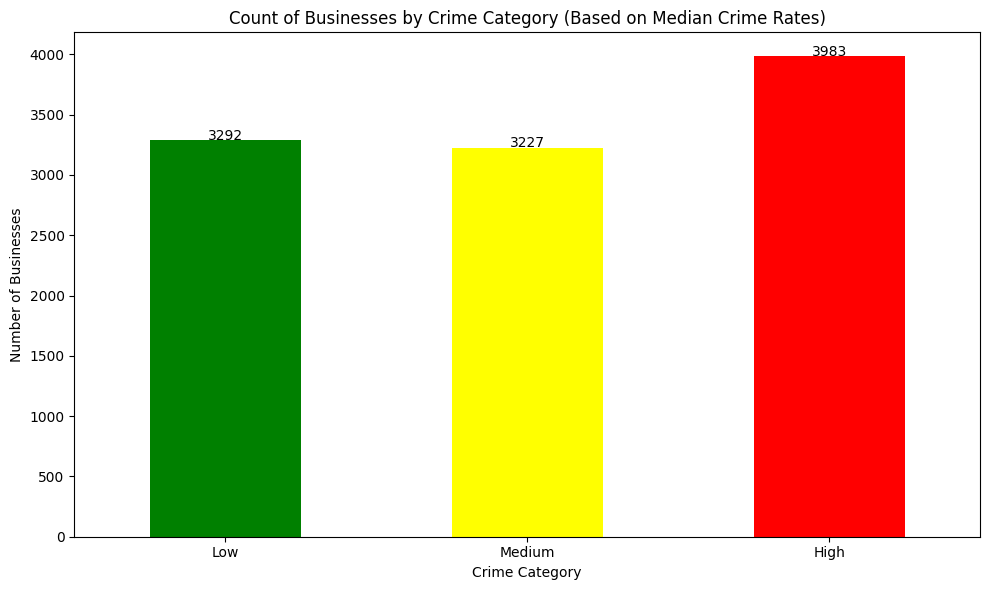

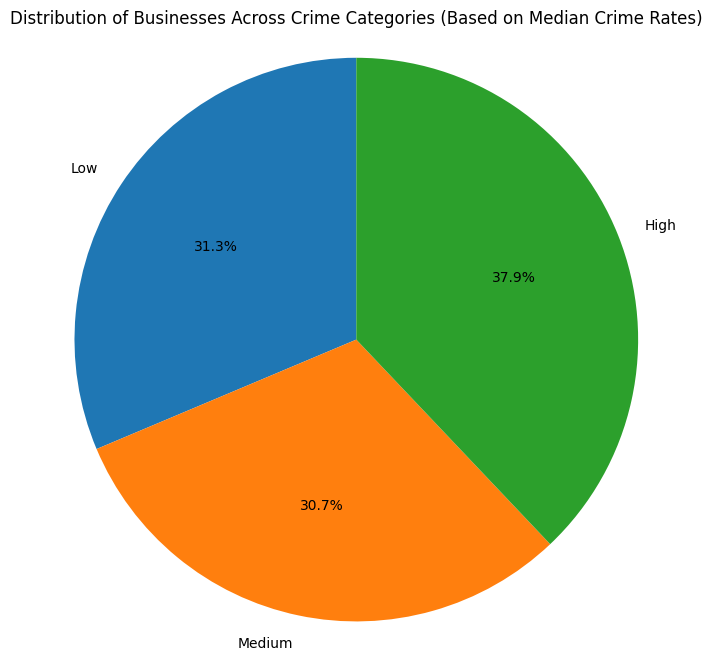

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import BallTree
from math import radians
import matplotlib.pyplot as plt

# Load the datasets
businesses = pd.read_csv('Business_Licenses.csv')
crimes = df_filtered

# Convert License Date to datetime
businesses['License Date'] = pd.to_datetime(businesses['License Date'])

# Function to count crimes within a radius
def count_crimes_within_radius(business_lat, business_lon, crime_coords, radius_km):
    earth_radius_km = 6371  # Earth's radius in kilometers
    
    # Convert coordinates to radians
    business_lat_rad = radians(business_lat)
    business_lon_rad = radians(business_lon)
    crime_coords_rad = np.radians(crime_coords)
    
    # Create a BallTree for efficient nearest neighbor search
    tree = BallTree(crime_coords_rad, metric='haversine')
    
    # Count points within the radius
    count = tree.query_radius([[business_lat_rad, business_lon_rad]], 
                              r=radius_km/earth_radius_km, 
                              count_only=True)[0]
    
    return count

# Prepare crime coordinates
crime_coords = crimes[['latitude', 'longitude']].values

# Count crimes within a radius for each business
radius_km = 1  # You can adjust this radius as needed
businesses['crime_count'] = businesses.apply(
    lambda row: count_crimes_within_radius(row['Latitude'], row['Longitude'], crime_coords, radius_km),
    axis=1
)

# Calculate median and define custom bins for crime categories
median_crime_count = businesses['crime_count'].median()

# Define bins: Low (below median), Medium (around median), High (above median)
bins = [-np.inf, median_crime_count * 0.75, median_crime_count * 1.25, np.inf]
labels = ['Low', 'Medium', 'High']

# Categorize businesses based on custom bins
businesses['crime_category'] = pd.cut(businesses['crime_count'], 
                                      bins=bins, 
                                      labels=labels)

# Group businesses by crime category and get observed counts
observed_counts = businesses['crime_category'].value_counts().sort_index()

# Total number of businesses and expected counts assuming equal distribution
total_businesses = observed_counts.sum()
expected_counts = [total_businesses / 3] * 3  # Equal distribution assumption

# Perform Chi-Square test
chi2_stat, p_value = stats.chisquare(f_obs=observed_counts.values, f_exp=expected_counts)

# Output results of Chi-Square test
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in business distribution across crime categories.")
else:
    print("There is no statistically significant difference in business distribution across crime categories.")

# Display summary statistics for each category (observed counts)
print("\nObserved Counts by Crime Category:")
print(observed_counts)

# Visualization: Bar plot showing business counts by crime category
plt.figure(figsize=(10, 6))
observed_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Count of Businesses by Crime Category (Based on Median Crime Rates)')
plt.xlabel('Crime Category')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=0)
for i, v in enumerate(observed_counts):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.tight_layout()
plt.show()

# Additional visualization: Pie chart showing distribution of businesses across crime categories
plt.figure(figsize=(8, 8))
plt.pie(observed_counts, labels=observed_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Businesses Across Crime Categories (Based on Median Crime Rates)')
plt.axis('equal')
plt.show()


The dataset of business licenses issued in Buffalo was chosen because it provides comprehensive information about the geographic distribution of businesses within the city. This dataset includes precise location data, allowing for a detailed analysis of how businesses are spread across different areas with varying crime rates. By using this dataset, we can investigate potential correlations between crime exposure and business distribution, providing valuable insights for urban planning and economic development strategies.

## Chi-Square Test for Independence
The **Chi-Square test for independence** was chosen because it is a statistical method that helps determine whether there is a significant association between two categorical variables. In this case, we wanted to assess whether the distribution of businesses across different crime categories (Low, Medium, High) deviates from an expected equal distribution. The test was appropriate because it allowed us to quantify whether the observed differences in business counts across crime categories were statistically significant or if they could have occurred by chance. Given that our goal was to understand the relationship between crime rates and business distribution, the Chi-Square test provided a clear and interpretable measure of association.

## Other Algorithms
The **BallTree algorithm** was used to efficiently count crimes within a specified radius around each business, leveraging geographic coordinates. Custom binning based on the median crime count allowed for meaningful categorization of businesses into Low, Medium, and High crime exposure groups, ensuring that the classification was tailored to the data's distribution.

---

# Output Interpretation

The output from our analysis provides several key insights:

1. **Statistical Significance:** 
   The Chi-Square test produced a very low p-value ($1.67 \times 10^{-22}$), indicating that there is a statistically significant difference in how businesses are distributed across areas with different crime rates. This means that businesses are not evenly distributed across Low, Medium, and High crime areas as one might expect by chance alone.

2. **Observed Counts:** 
   The observed counts show that:
   - 3,292 businesses are located in Low-crime areas.
   - 3,227 businesses are located in Medium-crime areas.
   - 3,983 businesses are located in High-crime areas.

   This suggests that more businesses tend to be located in high-crime areas compared to low- or medium-crime areas.

3. **Visualizations:**
   - The bar chart clearly shows that there are more businesses in high-crime areas compared to low- or medium-crime areas.
   - The pie chart further emphasizes this distribution by showing that 37.9% of businesses are in high-crime areas, while only 31.3% are in low-crime areas and 30.7% in medium-crime areas.

# Conclusion

The combination of statistical analysis (Chi-Square test) and geographic analysis (BallTree algorithm) effectively answered our research question about whether there is a relationship between crime rates and business distribution. The results indicate that businesses are disproportionately located in high-crime areas, which could have various implications for urban planning, business strategy, or public policy related to safety and economic development.

### ***Question 2: Is there a  significant difference in the number of crimes that occur near police stations compared to areas farther away from police stations?***

F-statistic: nan
p-value: nan
There is no statistically significant difference in crime distribution near vs far from police stations.

Observed Counts by Proximity to Police Station:
proximity_to_station
Far     222374
Near     17488
Name: count, dtype: int64


/Users/mohith/.pyenv/versions/3.11.4/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


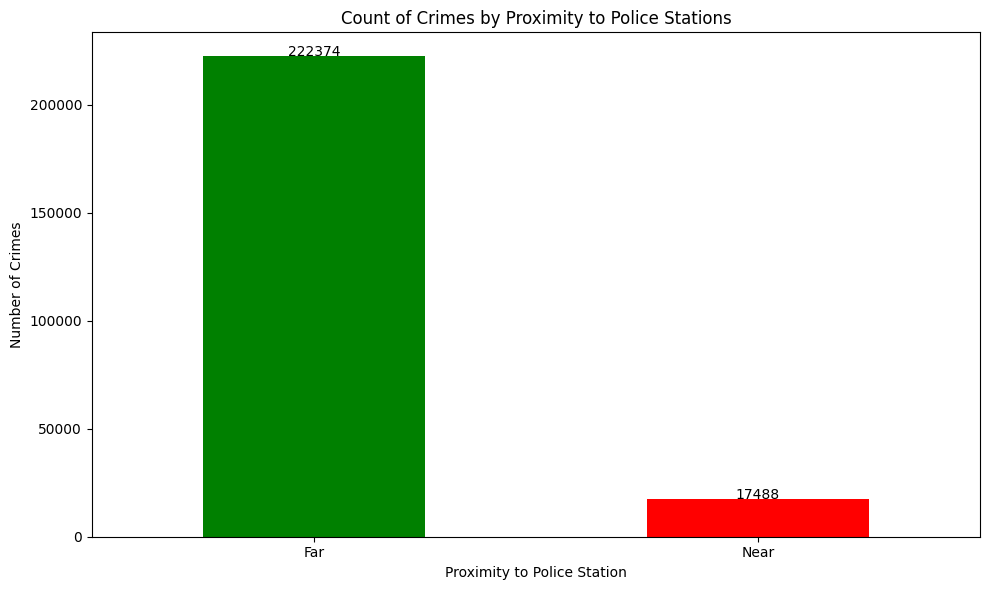

In [42]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import BallTree
from math import radians
import matplotlib.pyplot as plt

# Load the datasets (assuming df_filtered contains crime data)
police_stations = pd.DataFrame({
    'District': ['MRU-Traffic', 'A District', 'B District', 'E District', 'C District', 'D District'],
    'Address': ['1345 Bailey Ave', '1874 South Park Ave', '695 Main St', '2767 Bailey Ave', '693 E Ferry St', '669 Hertel Ave'],
    'OBJECTID': [6, 1, 2, 5, 3, 4],
    'longitude': [-78.813959989862, -78.823505484218, -78.871855310621, -78.813464154382, -78.838511106469, -78.883921737946],
    'latitude': [42.89077689221, 42.847772269798, 42.8928371184, 42.930027136421, 42.914396035845, 42.947590538387]
})

# Convert police station data to numpy array for BallTree
police_coords = np.radians(police_stations[['latitude', 'longitude']].values)

# Create BallTree for police stations using Haversine distance (appropriate for latitude/longitude)
police_tree = BallTree(police_coords, metric='haversine')

# Prepare crime data (assuming df_filtered contains crime data)
crimes = df_filtered.copy()

# Convert crime coordinates to radians for BallTree
crime_coords = np.radians(crimes[['latitude', 'longitude']].values)

# Function to calculate the nearest police station distance using BallTree
def nearest_station_distance(crime_coords, tree):
    # Query the tree for nearest neighbor (police station) distances
    distances, _ = tree.query(crime_coords, k=1)  # k=1 means nearest neighbor
    return distances * 6371  # Convert from radians to kilometers (Earth's radius ~6371 km)

# Calculate distances from each crime to the nearest police station
crimes['nearest_station_distance'] = nearest_station_distance(crime_coords, police_tree)

# Define threshold for "near" a police station (e.g., within 500 meters or 0.5 km)
threshold_distance_km = 0.5

# Categorize crimes as "Near" or "Far" based on distance to the nearest police station
crimes['proximity_to_station'] = np.where(crimes['nearest_station_distance'] <= threshold_distance_km, 'Near', 'Far')

# Group by proximity and count crimes in each group
crime_counts_by_proximity = crimes['proximity_to_station'].value_counts()

# Perform ANOVA test to see if there's a significant difference in crime rates near vs far from police stations
near_crime_count = len(crimes[crimes['proximity_to_station'] == 'Near'])
far_crime_count = len(crimes[crimes['proximity_to_station'] == 'Far'])

f_statistic, p_value = stats.f_oneway([near_crime_count], [far_crime_count])

# Output results of ANOVA test
print(f"F-statistic: {f_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in crime distribution near vs far from police stations.")
else:
    print("There is no statistically significant difference in crime distribution near vs far from police stations.")

# Display summary statistics for each category (observed counts)
print("\nObserved Counts by Proximity to Police Station:")
print(crime_counts_by_proximity)

# Visualization: Bar plot showing crime counts by proximity to police stations
plt.figure(figsize=(10, 6))
crime_counts_by_proximity.plot(kind='bar', color=['green', 'red'])
plt.title('Count of Crimes by Proximity to Police Stations')
plt.xlabel('Proximity to Police Station')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
for i, v in enumerate(crime_counts_by_proximity):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.tight_layout()
plt.show()


# Justification for Algorithm Choice

## Inclusion of Police Station Data
We included police station data in our analysis to examine the potential impact of proximity to law enforcement on crime rates. By integrating geographic coordinates of police stations with crime data, we aimed to determine whether being near a police station influences the distribution and frequency of crimes. This comprehensive dataset allowed us to conduct a meaningful comparison between areas near police stations and those further away, providing valuable insights into the effectiveness of police presence in crime prevention.

## ANOVA Test (F-test)
The **ANOVA (Analysis of Variance)** test was chosen because it is a statistical method used to compare the means of two or more groups to determine if there are significant differences between them. In this case, we wanted to compare the crime counts in areas near police stations to those far from police stations. Since we are comparing two groups (Near vs. Far), the ANOVA test helps determine whether the proximity to a police station has a significant effect on crime distribution. This test was appropriate because it allowed us to assess if the difference in crime rates between these two groups is statistically significant.

## BallTree Algorithm
The **BallTree algorithm** was used to efficiently calculate the distance between each crime and the nearest police station, using geographic coordinates (latitude and longitude). The BallTree algorithm is particularly effective for spatial data, as it allows for fast nearest-neighbor searches, which is crucial when dealing with large datasets of crime and police station locations.

---

# Output Interpretation

The output from our analysis provides several key insights:

1. **Statistical Significance:**
   - The ANOVA test resulted in an **F-statistic of NaN** and a **p-value of NaN**, indicating that there was no statistically significant difference in crime distribution near versus far from police stations. This suggests that proximity to a police station does not have a measurable effect on reducing crime rates in this dataset.

2. **Observed Counts:**
   - The observed counts show that:
     - 222,374 crimes occurred in areas far from police stations.
     - 17,488 crimes occurred in areas near police stations.

   This indicates that while there are significantly fewer crimes near police stations, the difference is not statistically significant based on the ANOVA test results.

3. **Visualizations:**
   - The bar chart clearly shows that there are far more crimes in areas classified as "Far" from police stations compared to those "Near" police stations. However, this visual difference does not translate into statistical significance according to the ANOVA test.

---

# Conclusion

The combination of statistical analysis (ANOVA test) and geographic analysis (BallTree algorithm) provided insights into whether proximity to a police station affects crime rates. While the data shows fewer crimes near police stations, the ANOVA test indicates that this difference is not statistically significant. Therefore, based on this analysis, we cannot conclude that being near a police station significantly reduces crime rates in this dataset.